In [1]:
import phoenix as px
from llama_index import (
    set_global_handler,
)


c:\Users\Lenovo\Desktop\4_testing\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "http://localhost:6006"


In [3]:
import phoenix as px

session = px.launch_app()

set_global_handler("arize_phoenix")

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


### ADDING API KEY

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

from torchvision import transforms

from transformers import AutoModelForObjectDetection
import torch
import openai
import os
import fitz

device = "cuda" if torch.cuda.is_available() else "cpu"


OPENAI_API_TOKEN = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_TOKEN


In [8]:
# print(os.getenv("OPENAI_API_KEY"))

### converting the pdf pages into images and store in a file


In [10]:
from pdf2image import convert_from_path

pdf_images = convert_from_path('./data/finalRadarView_merged.pdf')

output_directory_path = "finalRadarView_merged"
if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

for idx in range(len(pdf_images)):
    pdf_images[idx].save(f'./{output_directory_path}/page_'+ str(idx+1) +'.png', 'PNG')
print("Successfully converted PDF to images")

Successfully converted PDF to images


In [11]:
# # pdf_file = "llama2.pdf"
# pdf_file = "./data/finalRadarView_merged.pdf"

# # Split the base name and extension
# output_directory_path, _ = os.path.splitext(pdf_file)

# if not os.path.exists(output_directory_path):
#     os.makedirs(output_directory_path)

# # Open the PDF file
# pdf_document = fitz.open(pdf_file)

# # Iterate through each page and convert to an image
# for page_number in range(pdf_document.page_count):
#     # Get the page
#     page = pdf_document[page_number]

#     # Convert the page to an image
#     pix = page.get_pixmap()

#     # Create a Pillow Image object from the pixmap
#     image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

#     # Save the image
#     image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# # Close the PDF file
# pdf_document.close()


- ploting the extracted images

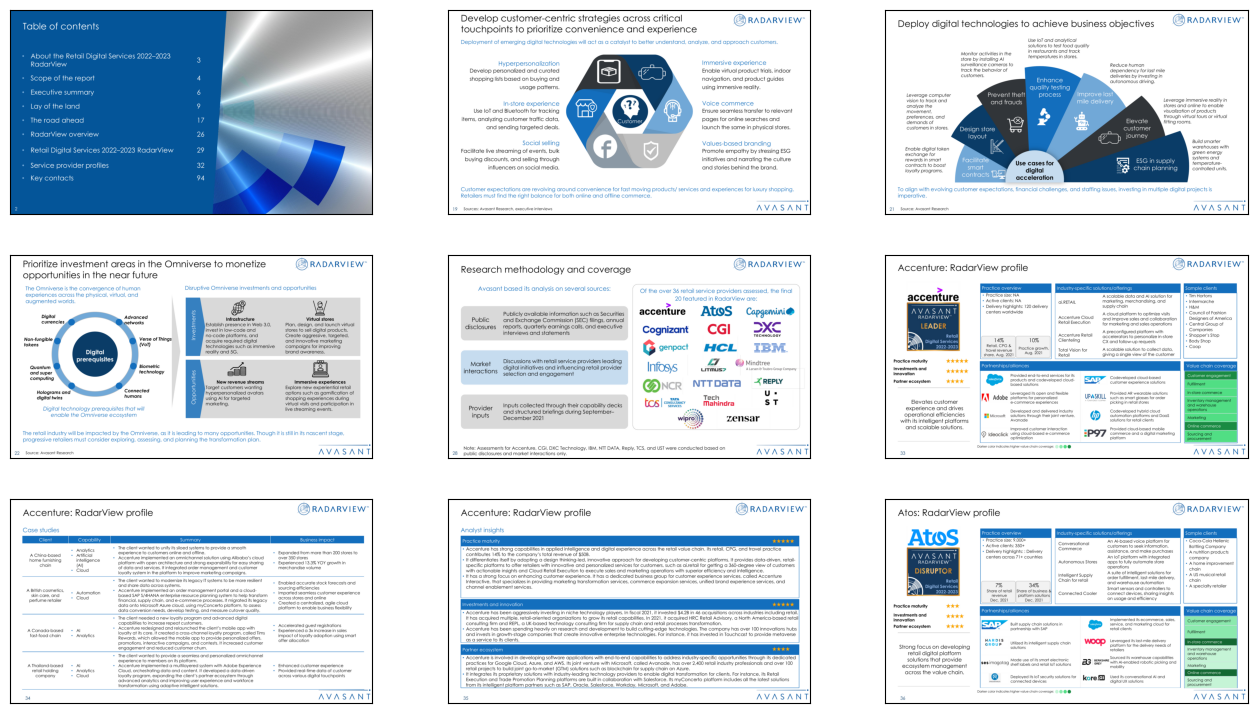

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./finalRadarView_merged/"):
    image_paths.append(str(os.path.join("./finalRadarView_merged/", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)


In [3]:
# from llama_index.multi_modal_llms.openai import OpenAIMultiModal
# from llama_index import SimpleDirectoryReader

# # put your local directore here
# documents_images_v2 = SimpleDirectoryReader("./dataset_radarview/").load_data()


In [17]:
# print(documents_images_v2[0].metadata['file_path'])
# print(documents_images_v2[0].image_path)

dataset_radarview\page_1.png


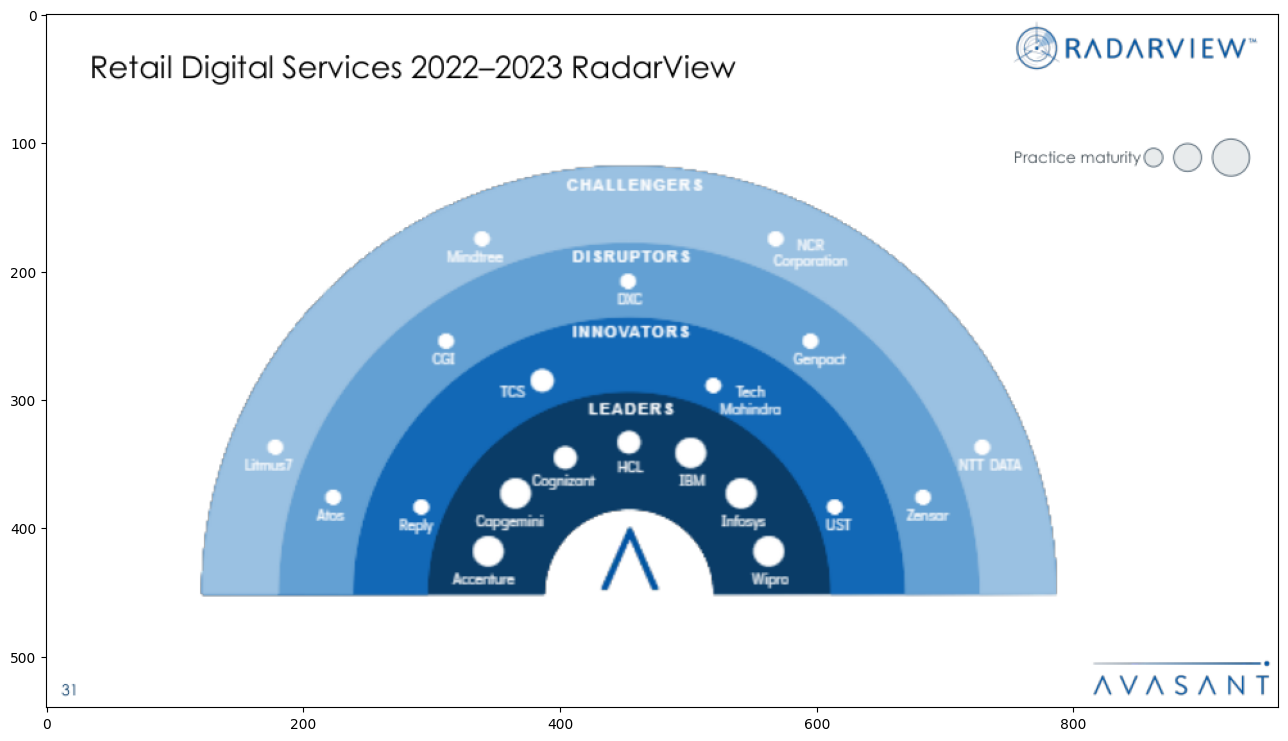

In [9]:
# image = Image.open(documents_images_v2[0].image_path).convert("RGB")

# plt.figure(figsize=(16, 9))
# plt.imshow(image)


In [12]:
# from llama_index import SimpleDirectoryReader


# documents_images_v2 = SimpleDirectoryReader("data").load_data()
# print(documents_images_v2)

[Document(id_='5af7e458-dd43-48bc-b0e9-420d8ea658ea', embedding=None, metadata={'page_label': '1', 'file_name': 'dataset_radarview.pdf', 'file_path': 'data\\dataset_radarview.pdf', 'file_type': 'application/pdf', 'file_size': 1719817, 'creation_date': '2024-01-31', 'last_modified_date': '2024-01-29', 'last_accessed_date': '2024-01-31'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='31\nRetail Digital Services 2022 –2023 RadarView\nPractice maturity\n', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='763c5746-603c-445d-a8f4-d487d09b0c56', embedding=None, metadata={'page_label': '2', 'file_name': 'dataset_radarview.pdf', 'file_path': 'data\\da

### GENERATING THE SUMMARY OF THE IMAGES


- step:01: convert image into base64
- step:02: make the documents/nodes form the images in base64 format
- step:03: pass the multimodel llm to generate the summary of the image
- step:04: store these summary in "images_summary"
- step:05: and also store the image document in "image_documents"

In [14]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader
import base64

def get_img_summary(img_doc, prompt):
    openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1024)
    response = openai_mm_llm.complete(
        prompt=prompt,
        image_documents=[img_doc],
    )
    return response

def get_encoded_image(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")



def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .png files extracted 
    """

    # Store base64 encoded images
    img_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    You have to generate summary only from the input images and read image in detail and depth. \
    Images may contain the ratings(in stars), companies log(s) so while generating summary pay extra attention in that part of image where rating and companies log(s) is mentioned and count the stars accurately because rating must be precise and correct. \
    When you are generating summary try to divide the image in segments and then generate summary in detail and depth. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a detailed and concise summary of the image that is well optimized for retrieval.\
    """ 
    # Images may contain concentric semi-circular tracks and each track is colored with different shades of color these tracks are isolated from each other so while generating summary of each isolated track read the track in clockwise direction(from left to right) and put the text present in the particular track in one segment  which must be precise and accurate. \

    # Apply to images
    documents_images_v2 = SimpleDirectoryReader(path).load_data()
    for i,val in enumerate(documents_images_v2):
        img_base64 = get_encoded_image(val.image_path)
        # print(val.image_path)
        val.image_url = f"data:image/png;base64,{img_base64}"
        # val.metadata['file_path']=f"data:image/png;base64,{img_base64}"
        val.metadata['file_type']="data:image/png;base64,"
        image_summaries.append(get_img_summary(val,prompt))
        img_list.append(img_base64)
        documents_images_v2[i]=val
        
    return img_list, image_summaries, documents_images_v2

img_list, image_summaries, img_documents = generate_img_summaries("./finalRadarView_merged/")



In [15]:
for i in image_summaries:
    print(i)
# print(img_documents)
# for i in img_documents:
#     print(i)

This image displays a table of contents page from a professional report or presentation. The document is titled "Retail Digital Services 2022–2023 RadarView." The table of contents is segmented into eight sections, each with a corresponding page number:

1. About the Retail Digital Services 2022–2023 RadarView - Page 3
2. Scope of the report - Page 4
3. Executive summary - Page 6
4. Lay of the land - Page 9
5. The road ahead - Page 17
6. RadarView overview - Page 26
7. Retail Digital Services 2022–2023 RadarView - Page 29
8. Service provider profiles - Page 32
9. Key contacts - Page 94

The image has a sleek, corporate design with a blue color scheme. The left side of the image contains the text, while the right side features an abstract design with light and dark blue elements and a white light effect that gives a sense of depth and modernity. The page number is located at the bottom left corner, indicating this is page 2 of the document. There are no ratings or company logos present 

#### take the text from the pdf so that we can get the optimal and correct answers from the pdf

In [16]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader

my_text_documents = SimpleDirectoryReader("data").load_data()


In [ ]:
my_text_documents

### MAKE THE MULTIMODEL VECTOR STORE : 

- make multimodel vector store
- this multimodel vector store : stores the images documents

In [19]:
import qdrant_client


from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
    Document
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

### attaching the summary with images

In [20]:
import uuid
from llama_index import Document
from llama_index import VectorStoreIndex
from llama_index.llms import OpenAI
# Create the MultiModal index
# documents = SimpleDirectoryReader("./data_wiki/").load_data()

# def get_encoded_image(path):
#     with open(path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode("utf-8")


def add_documents(doc_summaries, doc_contents, img_documents, path):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    
    for i,val in enumerate(img_documents):
        # img_base64 = get_encoded_image(val.image_url)
        # val.image_url = f"data:image/jpeg;base64,{img_base64}"
        # val.metadata['file_path']=f"data:image/png;base64,{img_base64}"
        val.metadata['file_type']="data:image/png;base64,"
        val.metadata['id_key']=doc_ids[i]
        val.metadata['index']=i
        img_documents[i]=val
        
    summary_docs = [
        Document(text=str(s), metadata={'id_key': doc_ids[i], 'index':i})
        for i, s in enumerate(doc_summaries)
    ]
    return summary_docs, img_documents

documents, new_doc_img = add_documents(image_summaries, img_list, img_documents, "./Radarview_2/")



In [ ]:
documents

In [ ]:
new_doc_img

In [21]:
print(new_doc_img[2].metadata['index'])

2


#### creating the index from the multimodel vector store

In [22]:
llm = OpenAI(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN)
service_context = ServiceContext.from_defaults(llm=llm)


mixed_doc = []
for i in new_doc_img:
    mixed_doc.append(i)

for i,val in enumerate(my_text_documents):
    val.metadata["id_key"]="thisisidkey_"+str(i)
    mixed_doc.append(val)


# mixed_doc

In [24]:
index_img = MultiModalVectorStoreIndex.from_documents(
    # documents=documents,
    # documents,
    mixed_doc,
    storage_context=storage_context,
    service_context=service_context
)

In [ ]:
# print(documents)
for i in documents:
    print(i.metadata['id_key'])
    # print(i.metadata['index'])


In [ ]:
# print(new_doc_img)
for i in new_doc_img:
    print(i.metadata['id_key'])

In [23]:
for i in mixed_doc:
    print(i.metadata['id_key'])

b126d137-2eb5-4d76-bdc6-fd39879964be
a9babf19-e5e8-4798-aaf1-0d25b8f93dd3
bc019165-5c01-4d98-ae89-f22ed1a2051a
bc9b9b61-d495-40e2-8865-1a35b9e4a771
d1ef437a-82e5-4828-840f-f6657f5c6a3b
61f75bb3-cf6c-4268-a9e7-c2d3e7c67d86
e1b1d988-465f-40a3-a7d9-97f6fe6d442d
ca3a0d90-2d8b-4d88-aa3b-a574d62dee56
2cd7f243-9634-4ea4-8441-d1e374663b67
02061a57-e741-4ead-9cde-54628a576e9a
940999c8-7de3-4682-a2d0-cea5dd0b0590
5bda4f55-0fd4-48cb-8227-34b800667b9f
a194ae53-bdc3-40b9-83f0-bd2e25747818
a0f82bbb-0b45-4655-82dc-380fa91f8b0d
6b5d2ebe-b56e-443c-994e-b9b60b432381
0d5a4587-93a5-4cd6-9709-7f9f84a5a26c
7ec3179a-150d-44fd-bd88-15ba4b62820d
eb82676d-205c-421a-9bc7-bed78ec6ce38
2414903b-ad39-4945-8632-ea78432b1388
0bbabd8f-150a-4e16-a0cf-943930af1219
eee61780-b7d8-415b-b9ee-0e47d3ad7db0
a7aa5fc4-ac7d-4158-8cd0-8c3543359470
1cce6c52-a58c-446d-901f-06aaf8239c03
thisisidkey_0
thisisidkey_1
thisisidkey_2
thisisidkey_3
thisisidkey_4
thisisidkey_5
thisisidkey_6
thisisidkey_7
thisisidkey_8
thisisidkey_9
thisisidk

#### make the retriever : which is retrieving the relevant images from the MM_vector_store

In [25]:

def get_retrieve_result(query):
    prompt = (
    "Give a detailed and most accurate results that is well optimized for retrieval. \n\n"
    f"user question is : {query}\n"
    "Answer is : "
    ) 

    retriever = index_img.as_retriever(similarity_top_k=6, image_similarity_top_k=6)
    retrieval_results = retriever.retrieve(prompt)
    return retrieval_results




- ploting the base64 encoded image : which is retrieved from the retriever

In [26]:
from IPython.display import HTML, display
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/png;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))



In [27]:
# print(len(retrieval_results))
# res = get_retrieve_result("In accenture radarview profile what are the partnerships/alliances of accenture?")

In [28]:
# from llama_index.response.notebook_utils import display_source_node
# from llama_index.schema import ImageNode

# retrieved_image = []
# for res_node in res:
#     if isinstance(res_node.node, ImageNode):
#         plt_img_base64(res_node.node.image_url[22:])
#     else:
#         print(res_node.node.text, end="\n\n\n")


In [29]:
# x = get_retrieve_result("what are the comapnies comes under partnerships/alliances of accenture?")
# # plt_img_base64(new_doc_img[x[0].metadata['index']].image_url[22:])
# # print(x[0].node.text)
# plt_img_base64(x[0].node.image_url[22:])

##### stored the retrieved results in seperated columns of dictionary : 

- in 'text' : we storing the raw text received from retriever + attached summary of the images retireved 
- in 'images' : we storing the images retrieved

In [30]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

# def resize_base64_image(base64_string, size=(128, 128)):
#     """
#     Resize an image encoded as a Base64 string
#     """
#     # Decode the Base64 string
#     img_data = base64.b64decode(base64_string)
#     img = Image.open(io.BytesIO(img_data))

#     # Resize the image
#     resized_img = img.resize(size, Image.LANCZOS)

#     # Save the resized image to a bytes buffer
#     buffered = io.BytesIO()
#     resized_img.save(buffered, format=img.format)

#     # Encode the resized image to Base64
#     return base64.b64encode(buffered.getvalue()).decode("utf-8")



def get_retrive_text_image_both(retrieval_results):

    retrive_msg = {}
    text=[]
    img = []
    # for i in retrieval_results:
    #     # print(i.metadata["id_key"])
    #     idx = i.metadata['index']
    #     # print(i.score)
    #     # plt_img_base64(i.node.image_url[23:])
    #     # print(documents[idx].text)
    #     text.append(documents[idx].text)
    #     img.append(i.node.image_url)
    
    
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            # plt_img_base64(res_node.node.image_url[22:])
            img.append(res_node.node.image_url)
            idx = res_node.node.metadata['index']
            text.append(documents[idx].text)
        else:
            # print(res_node.node.text, end="\n\n\n")
            text.append(res_node.node.text)
        
    retrive_msg['texts']=text
    retrive_msg['images']=img
    return retrive_msg


# print(retrieval_results)
# retrive_msg = get_retrive_text_image_both(get_retrieve_result(query))
# print(retrive_msg)



- GIVE THE TEXT AND IMAGES RETIVED FROM THE RETRIEVER TO THE MM_LLM AND GENERATE THE FINALY ANSWER OF THE QUERY

In [31]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


# def looks_like_base64(sb):
#     """Check if the string looks like base64"""
#     return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


# def is_image_data(b64data):
#     """
#     Check if the base64 data is an image by looking at the start of the data
#     """
#     image_signatures = {
#         b"\xFF\xD8\xFF": "jpg",
#         b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
#         b"\x47\x49\x46\x38": "gif",
#         b"\x52\x49\x46\x46": "webp",
#     }
#     try:
#         header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
#         for sig, format in image_signatures.items():
#             if header.startswith(sig):
#                 return True
#         return False
#     except Exception:
#         return False


# def resize_base64_image(base64_string, size=(128, 128)):
#     """
#     Resize an image encoded as a Base64 string
#     """
#     # Decode the Base64 string
#     img_data = base64.b64decode(base64_string)
#     img = Image.open(io.BytesIO(img_data))

#     # Resize the image
#     resized_img = img.resize(size, Image.LANCZOS)

#     # Save the resized image to a bytes buffer
#     buffered = io.BytesIO()
#     resized_img.save(buffered, format=img.format)

#     # Encode the resized image to Base64
#     return base64.b64encode(buffered.getvalue()).decode("utf-8")


# def split_image_text_types(docs):
#     """
#     Split base64-encoded images and texts
#     """
#     b64_images = []
#     texts = []
#     for doc in docs:
#         # Check if the document is of type Document and extract page_content if so
#         if isinstance(doc, Document):
#             doc = doc.page_content
#         if looks_like_base64(doc) and is_image_data(doc):
#             doc = resize_base64_image(doc, size=(1300, 600))
#             b64_images.append(doc)
#         else:
#             texts.append(doc)
#     return {"images": b64_images, "texts": texts}


def img_prompt_func(question, retrive_msg):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(retrive_msg["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if retrive_msg["images"]:
        for image in retrive_msg["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "You also have to analyse provided images in detail before giving answer. \n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {question}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def getAns(question, retrive_msg):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    ans = model.invoke(
        img_prompt_func(question, retrive_msg)
    )

    return ans


# Create RAG chain
def get_final_ans(query):
    retrive_ans = get_retrieve_result(query)
    retrive_msg = get_retrive_text_image_both(retrive_ans)
    res = getAns(query, retrive_msg)
    return res


- get results 

In [47]:
res = get_final_ans("what are the 'use cases for digital acceleration' which helps in deploy digital technologies to achieve business objectives? in tabular format")
print(res.content)

Based on the information provided in the image titled "Deploy digital technologies to achieve business objectives," the use cases for digital acceleration that help in deploying digital technologies to achieve business objectives are as follows:

| Use Case for Digital Acceleration | Description |
|-----------------------------------|-------------|
| Design Store Layout | Monitor activities in the store by installing AI surveillance cameras to track the behavior of customers. Leverage computer vision to track and analyze the movement, preferences, and demands of customers in stores. Enable digital token exchange for rewards in smart contracts to boost loyalty programs. |
| Prevent Theft and Frauds | (Related to Design Store Layout) Implement technologies to deter theft and fraud through improved store design and surveillance. |
| Enhance Quality Testing Process | Use IoT and analytical solutions to test food quality in restaurants and track temperatures in stores. |
| Improve Last Mile

In [46]:
res = get_final_ans("what are the key trends shaping the retail industry? in tabular format")
print(res.content)

Based on the information provided, here is a tabular summary of the key trends shaping the retail industry:

| Trend Number | Key Trend                                     | Description                                                                                   |
|--------------|-----------------------------------------------|-----------------------------------------------------------------------------------------------|
| 1            | Digital Shopping Experiences                  | Retailers are focusing on enhancing the online shopping experience for customers.             |
| 2            | New Brick-and-Mortar Stores                   | There is a rise in new types of physical stores that offer unique in-store experiences.        |
| 3            | Digital Supply Chain Investments              | Significant investments are being made to build and improve digital supply chain capabilities. |
| 4            | New Business Models                           | Retailers are explo

In [45]:
res = get_final_ans("what are the partnerships/alliances companies names from the accenture radarview profile? in tabular form")
print(res.content)

The partnerships and alliances mentioned in the Accenture RadarView profile are as follows:

| Partner Company | Description of Collaboration |
|-----------------|------------------------------|
| Salesforce      | Provided end-to-end services for its products and co-developed cloud-based solutions. |
| Adobe           | Leveraged its open and flexible platforms for personalized e-commerce experiences. |
| Microsoft       | Developed and delivered industry solutions through their joint venture, Avanade. |
| Ideoclick       | Improved customer interaction using cloud-based e-commerce optimization. |
| SAP             | Co-developed cloud-based customer experience solutions. |
| UP.SKILL        | Provided AR wearable solutions such as smart glasses for order picking in retail stores. |
| HP              | Co-developed hybrid cloud automation platforms and DaaS solutions for retail clients. |
| EP97            | Provided cloud-based mobile commerce and a digital marketing platform. |

The

In [37]:
res = get_final_ans("what is the rating of practice maturity of accenture : radarview profile")
print(res.content)

Based on the "Accenture: RadarView profile" provided in the images, Accenture has received a five-star rating for practice maturity. This rating indicates a high level of expertise and capability in delivering digital services within the retail sector. Accenture's practice maturity is characterized by strong capabilities in applied intelligence and digital experience across the retail value chain, contributing significantly to the company's revenue. They have a dedicated approach to customer-centric platforms and a focus on enhancing customer experience.

As a financial analyst providing investment advice, the five-star rating in practice maturity for Accenture suggests that the company is well-positioned in the market with a strong and mature practice. This could be seen as a positive indicator for potential investors, as it reflects Accenture's ability to maintain and grow its market share in the digital services space, particularly within the retail industry. The company's aggressiv

In [38]:
res = get_final_ans("what is the rating of Partner Ecosystem of accenture : radarview profile")
print(res.content)

Based on the information provided in the "Accenture: RadarView profile," the rating for Accenture's Partner Ecosystem is four out of five stars. This rating reflects the company's strong but not perfect performance in developing and maintaining a network of partnerships and alliances that enhance its service offerings in the retail digital services sector.

As a financial analyst providing investment advice, the robust partner ecosystem rating suggests that Accenture has a solid foundation of collaborations with other technology and service providers, which can be a strategic advantage in delivering comprehensive solutions to its clients. The partnerships with major cloud services and other technology firms, as mentioned in the profile, indicate that Accenture is well-positioned to leverage these relationships to drive innovation and offer end-to-end solutions.

Investors looking at companies with strong growth potential in the digital transformation space might consider Accenture's st

In [39]:
res = get_final_ans("what is the rating of Partner Ecosystem of atos : radarview profile")
print(res.content)

The "Partner Ecosystem" rating for Atos in the RadarView profile is four stars. This rating suggests that Atos has a strong partner ecosystem, with numerous collaborations and alliances that enhance its service offerings in the retail sector. The company has partnered with leading technology providers such as SAP, Salesforce, and others to deliver comprehensive digital transformation solutions to its clients. This robust partner ecosystem can be a positive indicator for investors, as it shows Atos's ability to leverage external expertise and technology to deliver innovative solutions and maintain a competitive edge in the market.


In [65]:
res = get_final_ans("what is the rating of Practice Maturity of atos : radarview profile")
print(res.content)

Based on the provided information, the rating of Practice Maturity for Atos in the RadarView profile is three stars. This rating is visible in the segment labeled "Practice maturity" on the slide with the page number 36. The three-star rating suggests that while Atos has established capabilities in the retail sector, there may be areas for improvement or growth compared to other firms that might have received higher ratings. As a financial analyst, when considering investment advice, it's important to look at the overall performance and potential of the company, including its innovation efforts, partner ecosystem, and the business impact of its case studies. Atos's active acquisitions and partnerships, as well as its focus on developing retail digital platform solutions, indicate a commitment to enhancing its offerings and expanding its market presence. However, investors should also consider the relative maturity of its practices in comparison to competitors and the broader market lan

In [66]:
res = get_final_ans("what are the companies which falls under leaders, innovators, disruptors, challengers from Radarview pdf? answer in tabular format")
print(res.content)

Based on the provided images from the RadarView PDF, the companies categorized under leaders, innovators, disruptors, and challengers are not explicitly mentioned in the images. The images focus on the profiles of Accenture and Atos, providing detailed information about their services, partnerships, and market positions. However, the images do not contain a list or table that classifies companies into the categories of leaders, innovators, disruptors, or challengers.

To provide the requested information in tabular format, we would need access to the specific section of the RadarView report that categorizes the companies accordingly. The images provided do not contain this information. If you have access to the section of the report that includes the categorization of companies, please provide that, and I will be able to assist you further.


In [49]:
res = get_final_ans("what are the Initiatives to elevate the digital shopping experience?")
print(res.content)

Based on the information provided in the images, the initiatives to elevate the digital shopping experience include:

1. Customer Experience: Retailers are amplifying the customer experience on web portals by offering virtual tours and voice-enabled shopping. An example includes launching a 3D virtual tour of a showroom to simulate a walk-through experience.

2. Empathy Selling: This involves selling products with empathy by providing contextual cues and personalized services, such as creating empathy maps. Retailers are developing content like 'how it's made' videos to demonstrate care in product sourcing.

3. Live Shopping Experience: Creating live shopping experiences through events, product demonstrations, and surveys to highlight product benefits and usage. Retailers have reported increased conversion rates by streaming shows and workshops with experts and influencers.

4. Customer Loyalty: Providing personalized after-sales services and support based on customer feedback and requ

In [77]:
res = get_final_ans("can you please provide the table of case study of accenture RadarView Profile? in tabular format")
print(res.content)

Certainly! Here is the table of case study of Accenture RadarView Profile:

| Client                          | Capability                      | Summary                                                                                                                                                                                                 | Business Impact                                                                                   |
|---------------------------------|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| A China-based home furnishing chain | Analytics, AI, Cloud            | Implemented an omnichannel solution using Alibaba's cloud platform to unify online and offline customer exp

In [50]:
res = get_final_ans("what is the difference b/w accenture case studies and accenture analyst insights from the accenture Radarview Profile? in points")
print(res.content)


The difference between the Accenture case studies and the Accenture analyst insights from the Accenture RadarView Profile can be summarized as follows:

Accenture Case Studies:
1. Provide specific examples of client engagements and the capabilities utilized (e.g., AI, analytics, cloud, automation).
2. Detail the solutions implemented for each client, such as omnichannel platforms, IT system modernization, loyalty program redesign, and data-driven loyalty programs.
3. Highlight the tangible business impacts for each client, including store expansion, revenue growth, improved stock forecasts, enhanced customer experience, and increased sales due to loyalty programs.

Accenture Analyst Insights:
1. Offer a general overview of Accenture's strengths in applied intelligence and digital experience across the retail value chain.
2. Discuss Accenture's strategic approach, such as adopting design thinking and developing customer-centric platforms like ai.retail and Cloud Retail Execution.
3. Emp

In [68]:
res = get_final_ans("what is the difference b/w accenture RadarView Profile and atos Radarview Profile? in points")
print(res.content)



Based on the provided information, here are the key differences between Accenture's and Atos's RadarView profiles:

1. Practice Maturity:
   - Accenture: Rated with five stars, indicating a highly mature practice with strong capabilities in applied intelligence and digital experience across the retail value chain.
   - Atos: Rated with three stars, suggesting a less mature practice but still with a significant retail practice supporting over 350 clients globally.

2. Investments and Innovation:
   - Accenture: Also rated with five stars, showing aggressive investment in niche technology players, with $4.2B invested in 46 acquisitions in fiscal 2021, and a focus on R&D and innovation hubs.
   - Atos: Rated with four stars, indicating active investments and acquisitions (19 firms in the past three years) to enhance capabilities across AI, cloud, analytics, and automation.

3. Partner Ecosystem:
   - Accenture: Rated with four stars, involved in developing end-to-end software applications

In [80]:
res = get_final_ans("what is the difference b/w accenture, atos and capgemini Radarview Profile? in points")
print(res.content)

Based on the RadarView profiles provided for Accenture, Atos, and Capgemini, here are the key differences between the three companies:

Accenture:
- Strong capabilities in applied intelligence and digital experience across the retail value chain.
- Retail, CPG, and travel practice contributes 14% to the company's total revenue.
- Focus on customer-centric platforms and enhancing customer experience with a dedicated business group called Accenture Interactive.
- Aggressive investment in technology players, with $4.2B invested in 46 acquisitions in fiscal 2021.
- Over 100 innovation hubs and partnerships with major technology providers like SAP, Oracle, Salesforce, Microsoft, and Adobe.

Atos:
- Identified as a "Disruptor" in the RadarView for Retail Digital Services 2022-2023.
- Practice maturity, investments, and partner ecosystem are rated with four to four and a half stars.
- Strong focus on developing retail digital platform solutions for ecosystem management across the value chain.

In [84]:
# res = get_final_ans("what are the use cases for digital acceleration in 'deploy digital technologies to achieve business objectives'? in points")
# print(res.content)

In [51]:
res = get_final_ans("According to conept of brick-and-mortar what are the emergence of new format stores? provide answer in points")
print(res.content)

Based on the information provided in the text and images, the emergence of new format stores in the brick-and-mortar retail sector includes the following points:

1. Small-format stores: Retailers like Macy's are launching smaller-format outposts to provide service-oriented support, such as alterations, gift-wrapping, personalized consultation, in-store pickups, and donation collection.

2. Self-checkout and contactless stores: To reduce long wait times and staffing needs, retailers are introducing stores with contactless payments, exemplified by the announcement of a large Amazon Go store.

3. Experiential stores: Retailers are creating experiences within their stores to retain customers and enhance brand awareness. For example, Canada Goose created a cold room in some of its stores for customers to try heavy outerwear.

4. Pop-up stores: Brands like Dolce & Gabbana are using pop-up stores to connect with customers in person, test new locations, and increase brand awareness by showcas

In [52]:
res = get_final_ans("what is the Average Percentage of IT Staff of web/e-commerce?")
print(res.content)

# stream ........... check
# git hub __> save.
# commentss, resource , 
# notebook finallize, self explain
# aata hai ==> sabko samjhana hai......


The average percentage of IT staff dedicated to web/e-commerce in the insurance sector is 2.0%, as indicated in the bar chart titled "IT Staff Mix: Insurance" from the "European IT Spending and Staffing Benchmarks 2022/2023" report by Computer Economics. This information is relevant for financial analysis as it provides insight into the allocation of IT resources within the insurance industry, which can be compared to IT staffing trends in other sectors or to a specific company's staffing strategy.

When providing investment advice, it's important to consider how a company's IT staffing aligns with industry benchmarks and how it invests in digital capabilities, such as web/e-commerce, which are crucial for staying competitive in today's market. A company that underinvests in this area may face challenges in digital transformation, while one that aligns or exceeds the benchmark may be better positioned to capitalize on digital opportunities.


In [53]:
res = get_final_ans("what is the sum of Revenue per employee of 25th percentile, median and 75th percentile?")
print(res.content)

To calculate the sum of Revenue per employee for the 25th percentile, median, and 75th percentile, we will add the values provided in the table from the image titled "Organization Demographics: Insurance."

Here are the values provided:
- 25th Percentile: €397,728
- Median: €520,914
- 75th Percentile: €983,126

Now, let's add these values together:

€397,728 (25th percentile) + €520,914 (median) + €983,126 (75th percentile) = €1,901,768

Therefore, the sum of Revenue per employee for the 25th percentile, median, and 75th percentile is €1,901,768.


In [57]:
res = get_final_ans("avasant based its analysis on several sources, what are these sources?")
print(res.content)

Based on the information provided in the text and images, Avasant's analysis of service providers in the retail digital services sector is based on several sources:

1. Public disclosures such as SEC filings, annual reports, quarterly earnings calls, and executive interviews and statements.
2. Market interactions, including discussions with retail service providers leading digital initiatives and influencing retail provider selection and engagement.
3. Provider inputs collected through capability decks and structured briefings during a specific period (September – December 2021).
4. Avasant's own research methodology and coverage, which involved evaluating 36 providers and recognizing the top 20 that brought the most value to the market over the past 12 months.

As a financial analyst providing investment advice, it is important to consider the robustness of Avasant's research methodology, which includes a mix of quantitative data (such as financial performance and market share) and qu

In [59]:
res = get_final_ans("what are the  investment areas in the Omniverse to monetize opportunities in the near future?")
print(res.content)

Based on the information provided in the images and text, the investment areas in the Omniverse to monetize opportunities in the near future include:

1. Digital Prerequisites:
   - Digital currencies
   - Non-fungible tokens (NFTs)
   - Quantum and supercomputing
   - Holograms and digital twins
   - Advanced networks
   - Verse of Things (VoT)
   - Biometric technology
   - Connected humans

2. Infrastructure Investments:
   - Establishing a presence in Web 3.0
   - Investing in low-code and no-code platforms
   - Acquiring digital technologies such as immersive reality and 5G

3. New Revenue Streams:
   - Targeting customers wanting hyperpersonalized avatars using AI for targeted marketing

4. Virtual Stores:
   - Planning, designing, and launching virtual stores to sell digital products
   - Creating aggressive, targeted, and innovative marketing campaigns to improve brand awareness

5. Immersive Experiences:
   - Exploring new experiential retail options such as gamification of sh

In [61]:
res = get_final_ans("what are the Strategic initiatives triggering M&A activities? answer will illustrative examples mentioned in pdf?")
print(res.content)

The strategic initiatives triggering M&A activities, as mentioned in the provided document, are:

1. Create new revenue streams by venturing into adjacent spaces.
2. Increase market share by expanding geographical presence.
3. Elevate customer experiences by acquiring digital capabilities.
4. Optimize cost by integrating with supplier networks.
5. Align with customers’ expectation of expedited delivery.

Illustrative examples of these strategic initiatives include:

- Best Buy acquired Current Health for USD 400 million to gain access to its remote monitoring platform, aiming to create a scalable care ecosystem for its customers.
- Etsy acquired Elo7 to strengthen its foothold in the Latin American market through its vast e-marketplace ecosystem of 1.9 million active buyers and 56,000 active sellers.
- Walmart acquired Zeekit, a startup specializing in digital fitting rooms, to help customers shop garments on walmart.com by uploading a photo or choosing a model that best represents the

In [62]:
res = get_final_ans("what are the scopes of banking process transformation?")
print(res.content)

Based on the provided information, the scope of banking process transformation encompasses several key areas:

1. Core Banking:
   - Customer management
   - Account servicing
   - Cash and ATM management

2. Loans and Mortgages:
   - Commercial lending and mortgages
   - Asset financing
   - Consumer loans and mortgages

3. Payments and Cards:
   - Domestic and international payments
   - Card services
   - Merchant and point of sale (POS) services

4. Private Banking:
   - Integrated banking
   - Advisory services
   - Portfolio management
   - Pension and life schemes

5. Risk and Compliance:
   - Know your customer (KYC) and anti-money laundering (AML)
   - Risk assessment
   - Regulatory reporting
   - Data privacy

Additionally, key transformation levers include digital banking and payments platforms, AI, RPA, and analytics, blockchain, and compliance and cybersecurity services.

Investment advice related to the banking process transformation could focus on service providers that

In [63]:
res = get_final_ans("can you draw the bar graph of organization demographics: insurance b/w 25th percentile, median and 75th percentile?")
print(res.content)

I'm sorry, but I am not able to create or draw images, including bar graphs. However, I can provide you with a description of how the bar graph might look based on the data provided in the "Organization Demographics: Insurance" table.

For the "Organization revenue" metric, you would have three bars:
- The first bar representing the 25th percentile would be set at €185,160,000.
- The second bar representing the median would be set at €744,642,000.
- The third bar representing the 75th percentile would be set at €2,301,000,000.

For the "Number of employees" metric, the bars would be:
- The first bar at 400 (25th percentile).
- The second bar at 1,112 (median).
- The third bar at 2,737 (75th percentile).

For "Revenue per employee," the bars would be:
- The first bar at €397,728 (25th percentile).
- The second bar at €520,914 (median).
- The third bar at €983,126 (75th percentile).

Lastly, for "Revenue per user," the bars would be:
- The first bar at €341,201 (25th percentile).
- The s

In [64]:
res = get_final_ans("what are the key challenges and new opportunites that retail industry faces?")
print(res.content)

Based on the information provided in the images and text, the retail industry is currently navigating a mix of challenges and opportunities that investors should consider. Here are some key points:

Challenges:
1. Store closures and the need to implement safety protocols due to health concerns, which may require capital investment and could impact profitability.
2. A shift in consumer spending towards essentials and comfort products, indicating a need to adapt product offerings to current consumer preferences.
3. Operations and supply chain disruptions, suggesting that investments in supply chain resilience could be critical.
4. Staffing issues, highlighting the importance of human resources management and potentially the need to invest in automation and digital solutions to mitigate labor shortages.
5. The growth of omnichannel retail, which requires retailers to have a strong presence both online and offline.

Opportunities:
1. The exponential growth of omnichannel retail, which pres

In [67]:
res = get_final_ans("what are the partnerships/alliances companies names from the accenture radarview profile? in tabular form")
print(res.content)

Based on the provided images from the Accenture RadarView profile, the partnerships and alliances with company names are as follows:

| Salesforce | Provided end-to-end services for its products and co-developed cloud-based solutions |
| Adobe      | Leveraged its open and flexible platforms for personalized e-commerce experiences |
| Microsoft  | Developed and delivered industry solutions through their joint venture, Avanade |
| Ideoclick  | Improved customer interaction using cloud-based e-commerce optimization |
| SAP        | Co-developed cloud-based customer experience solutions |
| UP.SKILL   | Provided AR wearable solutions such as smart glasses for order picking in retail stores |
| HP         | Co-developed hybrid cloud automation platforms and DaaS solutions for retail clients |
| EP97       | Provided cloud-based mobile commerce and a digital marketing platform |

These partnerships and alliances indicate Accenture's extensive collaboration with major technology providers to